# 5. 顧客の退会を予測する10本ノック

決定木を用いて顧客退会を予測する流れを学ぶ。

## 5.41. データの読み込み・整形

In [1]:
import pandas as pd

customer = pd.read_csv("customer_join.csv")
uselog_months = pd.read_csv("use_log_months.csv")

In [2]:
year_months = list(uselog_months["年月"].unique())

uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_0"}, inplace=True)

    tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-1]]
    tmp_before.drop("年月", axis=1, inplace=True)
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)

    tmp = pd.merge(tmp, tmp_before, on=["customer_id"], how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)

uselog.head()

/tmp/ipykernel_11380/2818734399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.rename(columns={"count":"count_0"}, inplace=True)
/tmp/ipykernel_11380/2818734399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.drop("年月", axis=1, inplace=True)
/tmp/ipykernel_11380/2818734399.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_before.rename(columns={"count":"count_1"}, inplace=True)
/tmp/ipykernel_11380/281873

,年月,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


## 5.42. 退会前月の退会顧客データの作成

翌月末退会なので、「退会前月（退会申請） → 退会月（退会申請済み） → 退会」の流れになる

In [3]:
from dateutil.relativedelta import relativedelta

exit_customer = customer.loc[customer["is_deleted"]==1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)
exit_customer["年月"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")
uselog["年月"] = uselog["年月"].astype(str)

exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "年月"], how="left")

print(len(uselog))
exit_uselog.head()

/tmp/ipykernel_11380/3772310182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["exit_date"] = None
/tmp/ipykernel_11380/3772310182.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
/tmp/ipykernel_11380/3772310182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

33851


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 欠損データを除く
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

1104
1104


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
19,201805,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,201805,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,201805,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,201805,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,201805,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,通常,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


## 5.43. 継続顧客のデータ作成

In [5]:
conti_customer = customer.loc[customer["is_deleted"]==0]
conti_uselog = pd.merge(uselog, conti_customer, on=["customer_id"], how="left")
print(len(conti_uselog))
conti_uselog = conti_uselog.dropna(subset=["name"])
print(len(conti_uselog))

33851
27422


In [6]:
# 退会顧客に対して多すぎるので重複を削除
conti_uselog = conti_uselog.sample(frac=1).reset_index(drop=True)
conti_uselog = conti_uselog.drop_duplicates(subset="customer_id")
print(len(conti_uselog))
conti_uselog.head()

2842


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201901,HD167407,7,6.0,XXXXXX,C01,F,2017-09-01,NaN,CA1,...,オールタイム,10500.0,通常,6.500000,7.0,8.0,4.0,1.0,2019-04-30,19.0
1,201808,GD574177,7,7.0,XXXX,C01,M,2017-11-01,NaN,CA1,...,オールタイム,10500.0,通常,6.333333,7.0,9.0,4.0,1.0,2019-04-30,17.0
2,201808,HI599889,8,6.0,XXXXXX,C01,M,2018-04-13,NaN,CA3,...,オールタイム,10500.0,入会費無料,7.083333,6.5,10.0,6.0,1.0,2019-04-30,12.0
3,201812,OA702752,6,6.0,XXXX,C01,M,2016-12-01,NaN,CA1,...,オールタイム,10500.0,通常,5.583333,5.5,8.0,4.0,1.0,2019-04-30,28.0
4,201806,HD139654,4,5.0,XXXX,C01,M,2017-01-01,NaN,CA1,...,オールタイム,10500.0,通常,5.416667,5.0,10.0,3.0,1.0,2019-04-30,27.0


In [7]:
# 結合
predict_data = pd.concat([conti_uselog, exit_uselog], ignore_index=True)
print(len(predict_data))
predict_data.head()

3946


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201901,HD167407,7,6.0,XXXXXX,C01,F,2017-09-01,NaT,CA1,...,10500.0,通常,6.500000,7.0,8.0,4.0,1.0,2019-04-30,19.0,NaN
1,201808,GD574177,7,7.0,XXXX,C01,M,2017-11-01,NaT,CA1,...,10500.0,通常,6.333333,7.0,9.0,4.0,1.0,2019-04-30,17.0,NaN
2,201808,HI599889,8,6.0,XXXXXX,C01,M,2018-04-13,NaT,CA3,...,10500.0,入会費無料,7.083333,6.5,10.0,6.0,1.0,2019-04-30,12.0,NaN
3,201812,OA702752,6,6.0,XXXX,C01,M,2016-12-01,NaT,CA1,...,10500.0,通常,5.583333,5.5,8.0,4.0,1.0,2019-04-30,28.0,NaN
4,201806,HD139654,4,5.0,XXXX,C01,M,2017-01-01,NaT,CA1,...,10500.0,通常,5.416667,5.0,10.0,3.0,1.0,2019-04-30,27.0,NaN


## 5.44. 予測する月の在籍期間の作成

In [8]:
predict_data["period"] = 0

predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = int(delta.years*12 + delta.months)

predict_data.head()

/tmp/ipykernel_11380/3178846796.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = int(delta.years*12 + delta.months)


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,period,now_date
0,201901,HD167407,7,6.0,XXXXXX,C01,F,2017-09-01,NaT,CA1,...,6.500000,7.0,8.0,4.0,1.0,2019-04-30,19.0,NaN,16,2019-01-01
1,201808,GD574177,7,7.0,XXXX,C01,M,2017-11-01,NaT,CA1,...,6.333333,7.0,9.0,4.0,1.0,2019-04-30,17.0,NaN,9,2018-08-01
2,201808,HI599889,8,6.0,XXXXXX,C01,M,2018-04-13,NaT,CA3,...,7.083333,6.5,10.0,6.0,1.0,2019-04-30,12.0,NaN,3,2018-08-01
3,201812,OA702752,6,6.0,XXXX,C01,M,2016-12-01,NaT,CA1,...,5.583333,5.5,8.0,4.0,1.0,2019-04-30,28.0,NaN,24,2018-12-01
4,201806,HD139654,4,5.0,XXXX,C01,M,2017-01-01,NaT,CA1,...,5.416667,5.0,10.0,3.0,1.0,2019-04-30,27.0,NaN,17,2018-06-01


## 5.45. 欠損値除去

In [9]:
predict_data.isna().sum()

年月                      0
customer_id             0
count_0                 0
count_1               270
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
period                  0
now_date                0
dtype: int64

In [10]:
# count_1 が欠損しているデータは問題なので除外
predict_data = predict_data.dropna(subset=["count_1"])
predict_data.isna().sum()

年月                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2624
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2624
period                  0
now_date                0
dtype: int64

## 5.46. 文字列型の変数を処理できるように整形

In [11]:
target_col = ["campaign_name", "class_name", "gender", "count_1", "routine_flg", "period", "is_deleted"]
predict_data = predict_data[target_col]
predict_data.head()

,campaign_name,class_name,gender,count_1,routine_flg,period,is_deleted
0,通常,オールタイム,F,6.0,1.0,16,0.0
1,通常,オールタイム,M,7.0,1.0,9,0.0
2,入会費無料,オールタイム,M,6.0,1.0,3,0.0
3,通常,オールタイム,M,6.0,1.0,24,0.0
4,通常,オールタイム,M,5.0,1.0,17,0.0


In [12]:
# ダミー変数化
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,gender_F,gender_M
0,6.0,1.0,16,0.0,0,0,1,1,0,0,1,0
1,7.0,1.0,9,0.0,0,0,1,1,0,0,0,1
2,6.0,1.0,3,0.0,0,1,0,1,0,0,0,1
3,6.0,1.0,24,0.0,0,0,1,1,0,0,0,1
4,5.0,1.0,17,0.0,0,0,1,1,0,0,0,1


In [13]:
# なくてもわかる情報は削除
del predict_data["campaign_name_通常"]
del predict_data["class_name_ナイト"]
del predict_data["gender_M"]
predict_data.head()

,count_1,routine_flg,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
0,6.0,1.0,16,0.0,0,0,1,0,1
1,7.0,1.0,9,0.0,0,0,1,0,0
2,6.0,1.0,3,0.0,0,1,1,0,0
3,6.0,1.0,24,0.0,0,0,1,0,0
4,5.0,1.0,17,0.0,0,0,1,0,0


## 5.47. 決定木を用いた退会予測モデルの作成

In [14]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection


exit = predict_data.loc[predict_data["is_deleted"]==1]
conti = predict_data.loc[predict_data["is_deleted"]==0].sample(len(exit))

X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(y_test_pred)

[0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.

In [15]:
results_test = pd.DataFrame({"y_test":y_test, "y_pred":y_test_pred})
results_test.head()

,y_test,y_pred
1716,0.0,0.0
1033,1.0,1.0
1899,0.0,0.0
391,1.0,1.0
778,1.0,0.0


## 5.48. 予測モデルの評価とモデルのチューニング

In [16]:
correct = len(results_test.loc[results_test["y_test"]==results_test["y_pred"]])
data_count = len(results_test)
score_test = correct / data_count
print(score_test)

0.8783269961977186


In [17]:
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.8783269961977186
0.9784537389100126


過学習傾向にあるのでチューニングする

In [18]:
# 決定木は木の深さを浅くしてモデルを簡易化出来る
X = pd.concat([exit, conti], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

model = DecisionTreeClassifier(random_state=0, max_depth=5)  # max_depth=5 を指定
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
print(model.score(X_train, y_train))

0.9182509505703422
0.9271229404309252


## 5.49. モデルに寄与している変数の確認

In [19]:
importance = pd.DataFrame({"feature_names":X.columns, "coefficient":model.feature_importances_})
importance

,feature_names,coefficient
0,count_1,0.347979
1,routine_flg,0.117873
2,period,0.526966
3,campaign_name_入会費半額,0.003586
4,campaign_name_入会費無料,0.000000
5,class_name_オールタイム,0.000000
6,class_name_デイタイム,0.003500
7,gender_F,0.000095


### 応用: graphviz による木構造の可視化

In [20]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    model,
    class_names="is_deleted",
    feature_names=X.columns,
    filled=True,
    rounded=True,
    out_file=None
)
graph = graphviz.Source(dot_data)

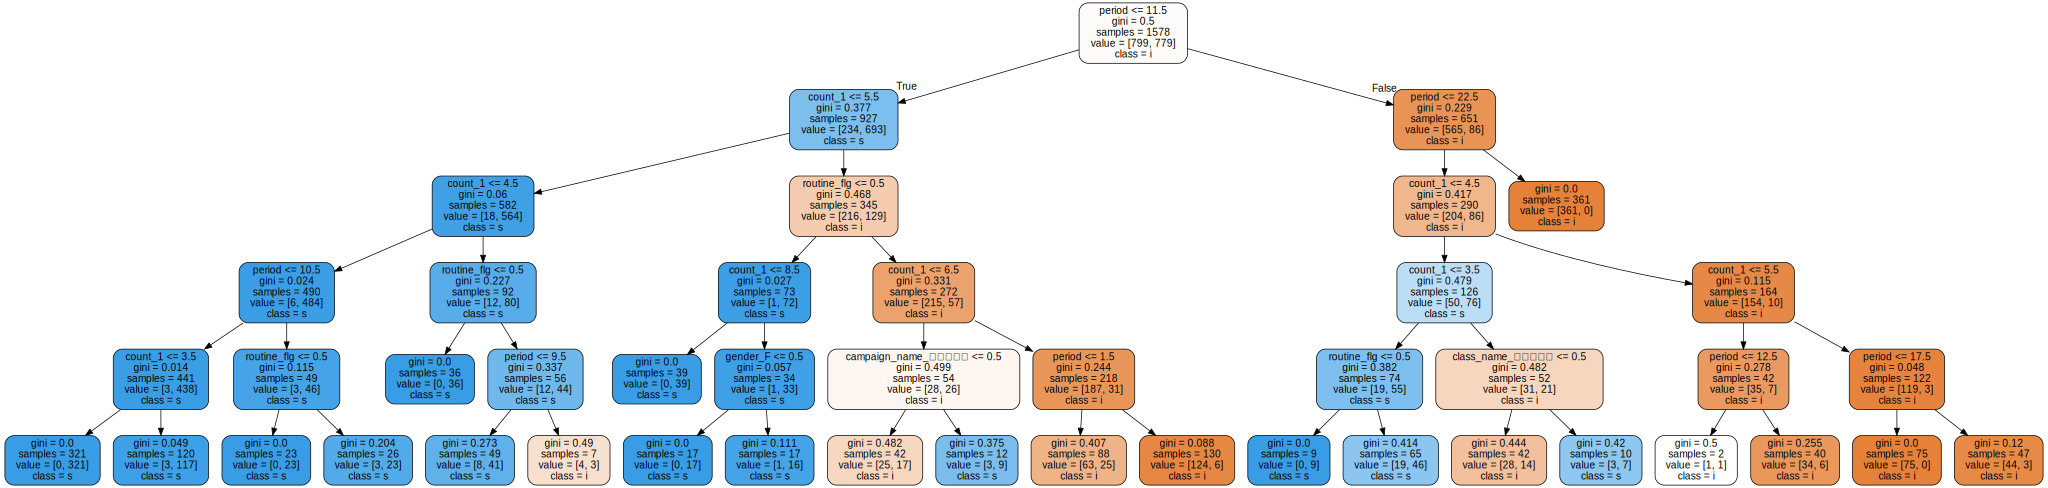

In [28]:
graph

## 5.50. 顧客の退会予測

In [22]:
# 顧客属性の定義
count_1 = 3
routine_flg = 1
period = 12
campaign_name = "入会費無料"
class_name = "オールタイム"
gender = "M"

In [23]:
# データ加工

if campaign_name == "入会費半額":
    campaign_name_list = [1, 0]
elif campaign_name == "入会費無料":
    campaign_name_list = [0, 1]
elif campaign_name == "通常":
    campaign_name_list = [0, 0]

if class_name == "オールタイム":
    class_name_list = [1, 0]
elif class_name == "デイタイム":
    class_name_list = [0, 1]
elif class_name == "ナイト":
    class_name_list = [0, 0]

if gender == "F":
    gender_list = [1]
elif gender == "M":
    gender_list = [0]

input_data = [count_1, routine_flg, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

In [24]:
print(model.predict([input_data]))
print(model.predict_proba([input_data]))

[1.]
[[0.29230769 0.70769231]]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
